# Delta Parameter Models: SVA, SS, and Global Tilt

This notebook develops machine learning models to predict postoperative changes in key sagittal alignment parameters, specifically Sagittal Vertical Axis, Sacral Slope, and Global Tilt. 


In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

from xgboost import XGBRegressor

from src import config

pd.set_option('display.max_columns', None)

## Data and Preprocessing

The models in this notebook use the cleaned dataset produced by the shared data cleaning pipeline. 


In [2]:
# Load cleaned data from config path

df = pd.read_csv(config.DATA_PROCESSED)
# df.columns = df.columns.astype(str).str.replace("\n"," ").str.replace(r"\s+"," ", regex=True).str.strip()

print(f"Loaded {df.shape[0]} patients, {df.shape[1]} columns")
print(f"Data path: {config.DATA_PROCESSED}")

Loaded 271 patients, 108 columns
Data path: /Users/hariharansureshkumar/Documents/GitHub/Data-Science-Capstone/data/processed/cleaned_for_modeling.csv


## Modeling Approach

For each alignment parameter, a regression model is trained to predict the postoperative change (postoperative value minus preoperative value). Features include patient demographics, preoperative alignment measurements, and surgical plan variables. An XGBoost regressor is used in combination with a preprocessing pipeline that handles missing values and categorical variables.


In [3]:
df

,id,age,sex,bmi,Race,LOS_min,LOS_hours,PROC_TIME_MIN,smoking,C7CSVL_preop,SVA_preop,TK_T4_T12_preop,TK_T10_L2_preop,T4PA_preop,L1PA_preop,L1PA_ideal,T4L1PA_preop,global_tilt_preop,LL_preop,L4S1_preop,L5S1_preop,PT_preop,PI_preop,PI_LL_preop,SS_preop,cobb_prox_curve_preop,EV_prox_prox_preop,EV_distal_prox_preop,cobb_main_curve_preop,EV_prox_main_preop,EV_distal_main_preop,cobb_distal_curve_preop,EV_prox_distal_preop,EV_distal_distal_preop,FC_preop,EV_prox_FC,tscore_femneck_preop,HU_UIV_preop,HU_UIVplus1_preop,HU_UIVplus2_preop,C7CSVL_postop,SVA_postop,TK_T4_T12_postop,TK_T10_L2_postop,PJA_postop,T4PA_postop,L1PA_postop,L1PA_ideal_mismatch_postop,T4L1PA_ideal_mismatch_postop,global_tilt_postop,LL_postop,L4_S1_postop,L5_S1_postop,PT_postop,PI_postop,PI_LL_postop,SS_postop,cobb_prox_curve_postop,EV_prox_prox_postop,EV_distal_prox_postop,cobb_main_curve_postop,EV_prox_main_postop,EV_distal_main_postop,cobb_distal_curve_postop,EV_prox_distal_postop,EV_distal_distal_postop,FC_postop,num_levels,num_interbody_fusion_levels,UIV_implant,ALIF,XLIF,TLIF,num_rods,num_pelvic_screws,osteotomy,mech_fail_last,RPV_preop,RPV_score_preop,RLL_preop,RLL_score_preop,LDI_preop,LDI_score_preop,RSA_preop,RSA_score_preop,gap_age_poin_preop,gap_score_preop,gap_category,RPV_postop,RPV_score_postop,RLL_postop,RLL_score_postop,LDI_postop,LDI_score_postop,RSA_postop,RSA_score_postop,gap_age_point_postop,gap_score_postop,gap_category_postop,CCI,ASA_CLASS,ODI_preop,ODI_6wks,ODI_3mo,ODI_6mo,ODI_12mo,num_levels_cat,revision
0,347180,76,FEMALE,27.42,White,6196,103.266667,106,0.0,16.9,95.9,38.6,0.4,27.3,20.3,5.10,7.0,39.6,29.3,17.9,10.7,30.3,52.2,22.9,21.9,14.4,T5,L2,20.4,L2,L4,11.3,L4,S1,11.3,L4,-1.5,93.0,85.0,116.0,NaN,98.2,39.3,4.2,14.8,16.2,12.0,6.90,4.2,25.5,47.6,27.2,14.1,16.0,52.3,4.7,36.3,9.7,T3,L1,11.0,L1,L4,8.9,L4,S1,8.9,9,0,FS,0,0,0,3,3,0,1.0,-17.898,3,-32.064,3,61.092150,0,29.544,3,1,10.0,SD,-3.557,0,-13.826,0,57.142857,0,15.396,1,1,2.0,P,4.0,2,NaN,NaN,NaN,NaN,NaN,lower,0
1,348636,65,FEMALE,18.94,White,3338,55.633333,115,0.0,-6.1,40.7,41.8,-7.5,7.4,9.1,1.90,-1.7,17.1,51.8,32.5,9.3,14.1,45.8,-6.0,31.7,40.0,T2,T7,60.2,T7,T12,43.5,T12,L5,10.6,L5,-0.5,229.0,245.0,248.0,-22.3,39.3,37.3,-5.5,11.2,8.8,12.9,11.00,-4.1,17.0,52.0,33.4,17.3,16.2,55.0,3.0,38.8,30.8,T1,T7,48.1,T7,T12,30.4,T12,L5,1.7,15,3,Hook,1,0,0,2,1,0,0.0,-4.322,0,-5.596,0,62.741313,0,10.116,1,1,2.0,P,-2.650,0,-11.100,0,64.230769,0,5.600,0,1,1.0,P,2.0,3,NaN,NaN,NaN,NaN,NaN,higher,0
2,391848,82,FEMALE,28.12,White,29906,498.433333,195,1.0,-18.0,136.5,38.8,26.6,23.6,5.8,-2.25,17.8,38.1,13.0,23.5,18.2,22.0,37.5,24.5,15.5,7.1,T7,T12,16.2,T12,L5,NaN,NaN,NaN,12.0,L3,NaN,138.0,137.0,136.0,-15.7,51.0,50.6,5.0,8.0,10.0,3.2,5.45,6.8,20.9,32.3,21.2,12.1,14.9,33.7,NaN,NaN,8.9,T8,L2,16.8,L2,L4,4.2,L4,S1,4.2,9,2,PS,0,0,0,3,3,0,0.0,-15.625,3,-39.250,3,180.769231,3,35.100,3,1,13.0,SD,-28.883,3,-17.594,2,65.634675,0,19.724,3,1,9.0,SD,4.0,3,0,0,0,NR,NR,lower,1
3,437448,69,FEMALE,21.33,White,13488,224.800000,132,1.0,-44.2,80.4,19.4,20.0,16.0,3.9,-2.05,12.1,25.3,14.4,38.1,13.2,12.4,37.9,23.5,25.5,31.0,T8,L1,47.5,L1,L4,NaN,NaN,NaN,15.4,L4,-1.2,184.0,180.0,213.0,-18.6,-43.4,41.8,15.1,7.2,5.4,-4.0,-1.95,9.4,7.0,45.6,38.5,25.7,5.4,33.8,-11.8,28.4,15.5,T8,L1,24.7,L1,L4,NaN,NaN,NaN,7.5,15,2,Hook,1,0,0,3,3,0,1.0,-5.861,0,-38.098,3,264.583333,3,22.108,3,1,10.0,SD,-0.542,0,-4.356,0,84.429825,3,5.776,0,1,4.0,MD,5.0,2,NaN,NaN,NaN,NaN,NaN,higher,0
4,501563,72,FEMALE,24.74,Multiple,18691,311.516667,246,1.0,-28.1,72.8,35.6,4.8,21.7,22.0,6.95,-0.3,35.6,55.0,23.2,16.1,22.8,55.9,0.9,33.1,15.9,T3,T9,27.9,T9,L3,24.6,L3,S1,24.6,L3,NaN,180.0,188.0,NaN,-11.8,-16.5,36.5,11.6,2.2,13.7,14.1,7.15,-0.4,20.7,57.4,35.4,17.1,22.0,49.5,-7.9,27.5,10.3,T3,T9,13.6,T9,L3,6.4,L3,L5,6.4,9,2,PS,1,0,0,3,2,0,1.0,-8.881,2,-8.658,0,42.181818,1,23.768,3,1,7.0,SD,-10.705,2,-2.290,0,61.672474,0,11.940,1,1,4.0,MD,3.0,2,NaN,NaN,NaN,NaN,NaN,lower,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [4]:
# Ensure delta columns exist
if "delta_SVA" not in df.columns:
    df["delta_SVA"] = df["SVA_postop"] - df["SVA_preop"]

if "delta_SS" not in df.columns:
    df["delta_SS"] = df["SS_postop"] - df["SS_preop"]


# Ensure delta_GlobalTilt exists
if "delta_GlobalTilt" not in df.columns:
    df["delta_GlobalTilt"] = (
        df["global_tilt_postop"] - df["global_tilt_preop"]
    )



In [5]:

# Use shared config for features


PATIENT_FIXED_COLS = config.PATIENT_FIXED_COLS
PLAN_COLS = config.PLAN_COLS

# Exclude GAP-related predictors for delta models
PREDICTORS = [p for p in PATIENT_FIXED_COLS if "gap" not in p]

FEATURES = PREDICTORS + PLAN_COLS

# Automatically split by dtype
NUMERIC_FEATURES = df[FEATURES].select_dtypes(
    exclude=["object", "string", "category"]
).columns.tolist()

CATEGORICAL_FEATURES = df[FEATURES].select_dtypes(
    include=["object", "string", "category"]
).columns.tolist()


In [6]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ]
)



In [7]:
def train_delta_model(df, target_col, model_name):
    data = df[FEATURES + [target_col]].dropna(subset=[target_col])

    X = data[FEATURES]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    pipe = Pipeline([
        ("preprocess", clone(preprocessor)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)

    print(f"\n{model_name}")
    print("MAE:", round(mean_absolute_error(y_test, preds), 3))
    print("R² :", round(r2_score(y_test, preds), 3))

    return pipe, X_test, y_test, preds


## Model Evaluation

Model performance is evaluated using mean absolute error (MAE) and R². These metrics provide a measure of prediction accuracy and the proportion of variance explained by the model. In addition to numerical metrics, diagnostic plots are used to assess prediction behavior and error patterns.


In [8]:
sva_model = train_delta_model(df, "delta_SVA", "ΔSVA Model")
ss_model  = train_delta_model(df, "delta_SS", "ΔSS Model")
gt_model  = train_delta_model(df, "delta_GlobalTilt", "ΔGlobal Tilt Model")



ΔSVA Model
MAE: 29.291
R² : 0.548

ΔSS Model
MAE: 7.258
R² : 0.238

ΔGlobal Tilt Model
MAE: 6.538
R² : 0.562


In [9]:
sva_model, X_test_sva, y_test_sva, y_pred_sva = train_delta_model(
    df, "delta_SVA", "ΔSVA Model"
)



ΔSVA Model
MAE: 29.291
R² : 0.548


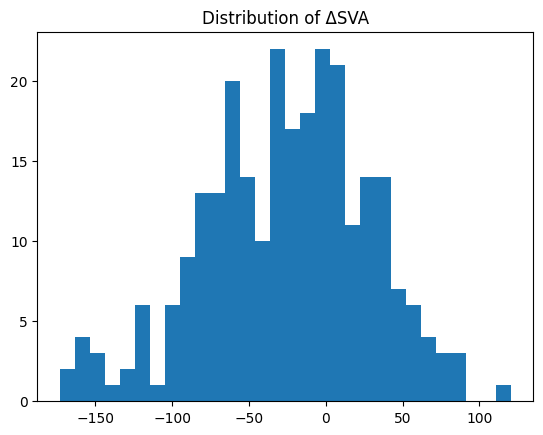

count    267.000000
mean     -25.518352
std       54.052148
min     -173.100000
25%      -61.450000
50%      -20.200000
75%       10.600000
max      120.400000
Name: delta_SVA, dtype: float64


In [13]:
plt.hist(df["delta_SVA"].dropna(), bins=30)
plt.title("Distribution of ΔSVA")
plt.show()

print(df["delta_SVA"].describe())

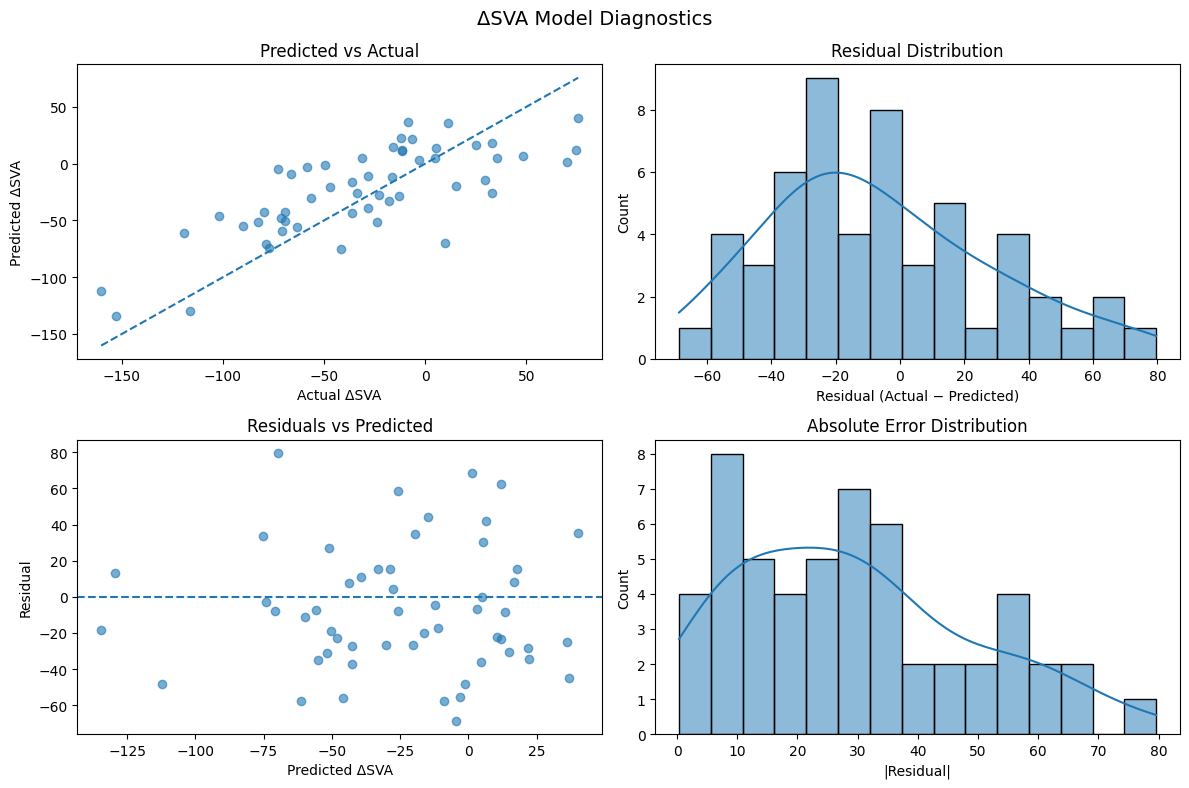

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

residuals = y_test_sva - y_pred_sva
abs_error = np.abs(residuals)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("ΔSVA Model Diagnostics", fontsize=14)

# -----------------------------
# 1️⃣ Predicted vs Actual
# -----------------------------
axes[0, 0].scatter(y_test_sva, y_pred_sva, alpha=0.6)
axes[0, 0].plot(
    [y_test_sva.min(), y_test_sva.max()],
    [y_test_sva.min(), y_test_sva.max()],
    linestyle="--"
)
axes[0, 0].set_title("Predicted vs Actual")
axes[0, 0].set_xlabel("Actual ΔSVA")
axes[0, 0].set_ylabel("Predicted ΔSVA")

# -----------------------------
# 2️⃣ Residual Distribution
# -----------------------------
sns.histplot(residuals, bins=15, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Residual Distribution")
axes[0, 1].set_xlabel("Residual (Actual − Predicted)")

# -----------------------------
# 3️⃣ Residual vs Predicted
# -----------------------------
axes[1, 0].scatter(y_pred_sva, residuals, alpha=0.6)
axes[1, 0].axhline(0, linestyle="--")
axes[1, 0].set_title("Residuals vs Predicted")
axes[1, 0].set_xlabel("Predicted ΔSVA")
axes[1, 0].set_ylabel("Residual")

# -----------------------------
# 4️⃣ Absolute Error Distribution
# -----------------------------
sns.histplot(abs_error, bins=15, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Absolute Error Distribution")
axes[1, 1].set_xlabel("|Residual|")

plt.tight_layout()
plt.show()

In [16]:
def build_final_delta_model(df, target_col):
    data = df[FEATURES + [target_col]].dropna(subset=[target_col])

    X_full = data[FEATURES]
    y_full = data[target_col]

    model = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    pipe = Pipeline([
        ("preprocess", clone(preprocessor)),
        ("model", model)
    ])

    pipe.fit(X_full, y_full)

    return pipe

In [17]:
sva_pipe = build_final_delta_model(df, "delta_SVA")
ss_pipe  = build_final_delta_model(df, "delta_SS")
gt_pipe  = build_final_delta_model(df, "delta_GlobalTilt")

## Save Models

Save trained models as joblib bundles containing the pipeline and feature list.

In [20]:
import joblib

# Build final full-data models
sva_pipe = build_final_delta_model(df, "delta_SVA")
ss_pipe  = build_final_delta_model(df, "delta_SS")
gt_pipe  = build_final_delta_model(df, "delta_GlobalTilt")

# Save SVA model
sva_dir = config.ARTIFACTS_DIR / "SVA"
sva_dir.mkdir(parents=True, exist_ok=True)

bundle_sva = {
    "pipe": sva_pipe,
    "features": FEATURES,
    "target": "delta_SVA",
    "model_name": "XGBRegressor_delta_SVA"
}

joblib.dump(bundle_sva, sva_dir / "delta_SVA_model.joblib")
print("Saved SVA model")

# Save SS model
ss_dir = config.ARTIFACTS_DIR / "SS"
ss_dir.mkdir(parents=True, exist_ok=True)

bundle_ss = {
    "pipe": ss_pipe,
    "features": FEATURES,
    "target": "delta_SS",
    "model_name": "XGBRegressor_delta_SS"
}

joblib.dump(bundle_ss, ss_dir / "delta_SS_model.joblib")
print("Saved SS model")

# Save Global Tilt model
gt_dir = config.ARTIFACTS_DIR / "GlobalTilt"
gt_dir.mkdir(parents=True, exist_ok=True)

bundle_gt = {
    "pipe": gt_pipe,
    "features": FEATURES,
    "target": "delta_GlobalTilt",
    "model_name": "XGBRegressor_delta_GlobalTilt"
}

joblib.dump(bundle_gt, gt_dir / "delta_GlobalTilt_model.joblib")
print("Saved Global Tilt model")

Saved SVA model
Saved SS model
Saved Global Tilt model
